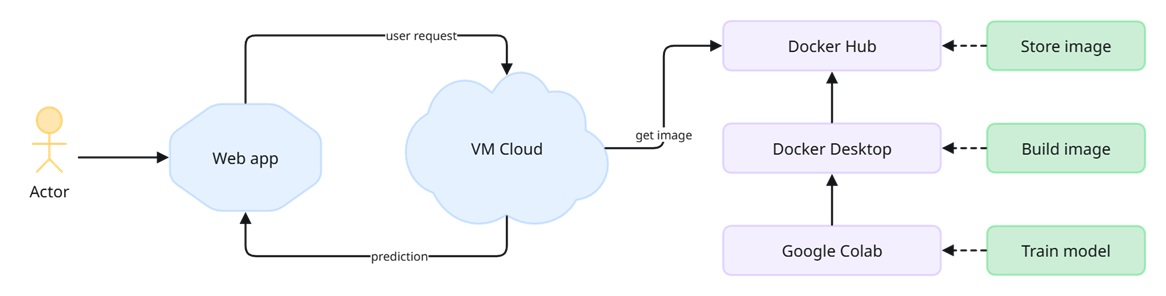

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, DistilBertConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [ ]:
# Load data
df = pd.read_excel('/content/df_colab.xlsx')

# Data manipulation
df['combined_text'] = df['text_col1'].astype(str) + ' ' + df['text_col2'].astype(str)
df.drop(columns=['text_col1', 'text_col2'], inplace=True)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')

label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['service_line'].unique()))}
train_df['service_line'] = train_df['service_line'].replace(label_to_idx).astype(int)
val_df['service_line'] = val_df['service_line'].replace(label_to_idx).fillna(-1).astype(int)

/tmp/ipython-input-1157253616.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['service_line'] = train_df['service_line'].replace(label_to_idx).astype(int)
/tmp/ipython-input-1157253616.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['service_line'] = val_df['service_line'].replace(label_to_idx).fillna(-1).astype(int)


In [ ]:
# Define class for dataset creation
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.texts)

# Create dataset
train_dataset = CustomDataset(train_df['combined_text'].values.tolist(), train_df['service_line'].values.tolist())
val_dataset = CustomDataset(val_df['combined_text'].values.tolist(), val_df['service_line'].values.tolist())

In [ ]:
# Define class for Early stopping
class EarlyStopping:
    """Stops training when validation loss stops improving."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Define function for metric calculation
def calculate_metrics(preds, labels):
    """
    Вычисляет accuracy и F1 score
    """
    preds_flat = np.array(preds)
    labels_flat = np.array(labels)
    acc = np.sum(preds_flat == labels_flat) / len(labels_flat)
    f1 = f1_score(labels_flat, preds_flat, average='weighted')
    return acc, f1

In [ ]:
# Define device location
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Model param's
batch_size = 16
num_classes = len(set(train_df['service_line']))
epochs = 15
dropout_prob = 0.06
config = DistilBertConfig.from_pretrained('distilbert-base-multilingual-cased', num_labels=num_classes, attn_dropout=dropout_prob, resid_dropout=dropout_prob)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', config=config)
model.to(device)

# Optimization param's
learning_rate=2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Data loader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Early Stopping param's
early_stopping = EarlyStopping(patience=5, verbose=True, path='./checkpoint_best_model.pt')
total_steps = len(train_dataloader) * epochs

# Learning rate Scheduler
warmup_steps = int(total_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)
print(f"Total training steps: {total_steps}, Warmup steps: {warmup_steps}")

# Train model
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}\n")
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Training ({epoch+1})")
    model.train()

    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        b_input_ids = batch['input_ids'].to(device)
        b_attention_masks = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        outputs = model(b_input_ids, attention_mask=b_attention_masks, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Валидация
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_ground_truth = []

    for batch in validation_dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_attention_masks = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_masks)

        logits = outputs.logits
        val_loss = criterion(logits.view(-1, num_classes), b_labels.view(-1))
        total_val_loss += val_loss.item()

        probs = torch.softmax(logits.detach(), dim=1)
        _, preds = torch.max(probs, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_ground_truth.extend(b_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(validation_dataloader)
    acc, f1 = calculate_metrics(all_predictions, all_ground_truth)
    val_losses.append(avg_val_loss)
    val_f1_scores.append(f1)
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {acc:.4f}, Weighted F1 Score: {f1:.4f}")

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
      print("Early stopping triggered")
      break

# Load best model
model.load_state_dict(torch.load('./checkpoint_best_model.pt'))
print("Loaded best model state_dict.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 27825, Warmup steps: 2782

Epoch 1/15



Training (1):   0%|          | 0/1855 [00:00<?, ?it/s]

In [ ]:
# Define plot for trian hoistory
plt.figure(figsize=(12, 4))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1')
plt.title('F1 over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.show()
plt.savefig('plot_history.png')

In [ ]:
# Define single test
def predict_category(model, input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    inputs = {k:v.to(device) for k,v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        _, pred = torch.max(probs, dim=1)

    return pred.item()

predicted_class = predict_category(model, "Ваш новый текст здесь")
print(f"Предсказанная категория: {predicted_class}")

In [ ]:
# Save training history to dataframe
params = {
    'batch_size': batch_size,
    'num_classes': num_classes,
    'optimizer': 'AdamW',
    'lr': learning_rate,
    'epochs': len(train_losses),
    'dropout_prob': dropout_prob}

columns = ["batch_size", "num_classes", "optimizer", "lr", "epochs", "dropout_prob", "acc", "f1", "avg_val_loss"]
result_df = pd.DataFrame(columns=columns)

new_row = [
    params["batch_size"],
    params["num_classes"],
    params["optimizer"],
    params["lr"],
    params["epochs"],
    params["dropout_prob"],
    acc,
    f1,
    avg_val_loss]
result_df.loc[len(result_df)] = new_row
display(result_df)


In [ ]:
# Save data
result_df.to_excel('/content/df_out.xlsx')